In [1]:
# Smarter Circuits #
import sys
sys.path.append('../')


import imagePreprocessing as ip
import graphGeneration as gg
import patternMatching as pm
import boundingBoxGeneration as bbg
import cuircitGeneration as cg
import componentClassification as cc
import matplotlib.pyplot as plt
import cv2
import lib.utils as utils
import os
import numpy as np
import random
import string
import igraph
import copy

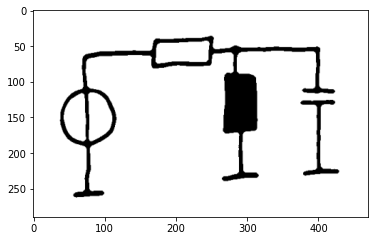

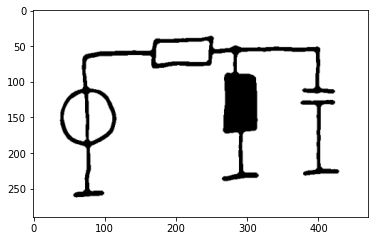

In [2]:
name = "10.png"

image = utils.loadImage(path="./../resources/testImages",name=name, resize=(450,None))

colorImage = utils.loadImage(path="./../resources/testImages",name=name, resize=(450,None), color=True)

#insert padding
s1 = np.full((len(image),10),255)
image = np.insert(image, [0], s1, axis=1)
image = np.insert(image, [len(image[0])], s1, axis=1)
s2 = np.full((10,len(image[0])),255)
image = np.insert(image, [0], s2, axis=0)
image = np.insert(image, [len(image)], s2, axis=0)

s1 = np.full((len(colorImage),10,3),255)

colorImage = np.insert(colorImage, [0], s1, axis=1)
colorImage = np.insert(colorImage, [len(colorImage[0])], s1, axis=1)
s2 = np.full((10,len(colorImage[0]),3),255)

colorImage = np.insert(colorImage, [0], s2, axis=0)
colorImage = np.insert(colorImage, [len(colorImage)], s2, axis=0)

plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(colorImage)

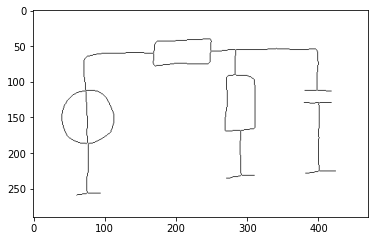

In [3]:
image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)[1]
preprocessedImage = ip.preprocessImage(image.copy())
utils.saveImage(name="preprocessed.png", image=preprocessedImage)

plt.imshow(preprocessedImage, cmap='gray')

In [4]:
#class_names = os.listdir('./../trainData')
#
#for class_name in class_names:
#    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))

def generateTrainData(boundingBoxes, image):
    print(boundingBoxes)
    counter = []
    for box in boundingBoxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        component = cv2.resize(component, (32,32), interpolation = cv2.INTER_AREA)
        #utils.saveImage(path='./../resources/trainData/')
        utils.saveImage(path='./../resources/trainData/', name="{i}.png".format(i=''.join(random.choice(string.ascii_lowercase) for i in range(10))), image=component)

7


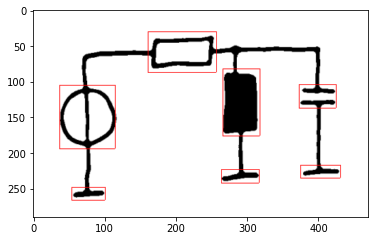

In [5]:
graph = gg.generateGraph(preprocessedImage)
matches_ = pm.getComponents(graph)
boundingBoxes_ = utils.fmap(lambda x: bbg.generateBoundingBox(x,preprocessedImage),matches_)
ziparu = zip(boundingBoxes_,matches_)

components = list(ziparu)

#generateTrainData(bb, image)

def drawRect(image,boundingBox,color):
    corner1 = boundingBox[0]
    corner2 = boundingBox[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        try:
            image[startY][x] = color
            image[endY][x] = color
        except:
            pass

    for y in range(startY,endY):
        try:
            image[y][startX] = color
            image[y][endX] = color
        except:
            pass

    return image


for box in boundingBoxes_:
    drawRect(colorImage,box,(255,0,0))
#colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")
print(len(components))

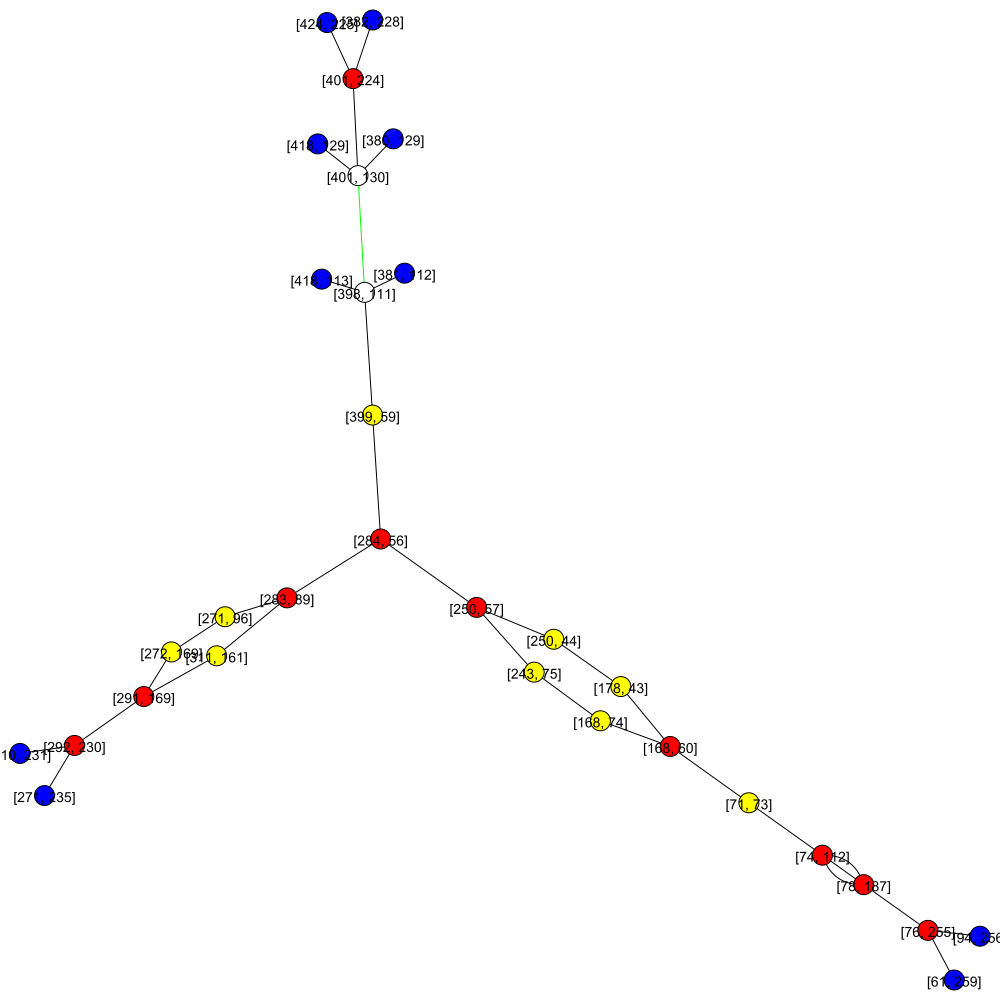

In [6]:
igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (1000,1000))

In [7]:
cc.loadModel()

predictions = []
for box in boundingBoxes_:
    buildingType = cc.predict(box,image)#[0]
    predictions.append(buildingType)

Biggest lenght of resistor 82


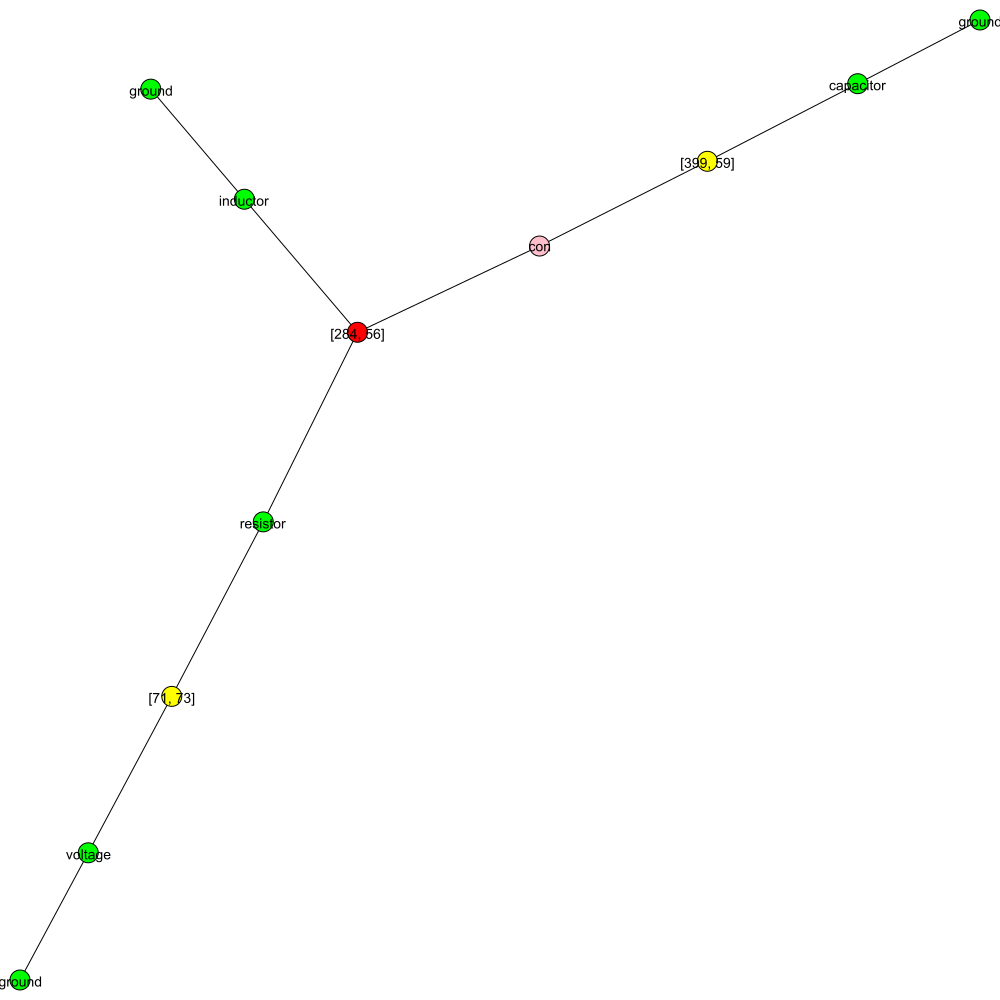

In [8]:
graph = cg.createLTSpiceFile(matches_,boundingBoxes_,predictions,copy.copy(graph),"./out.asc")

igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (1000,1000))